<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/jonasnylund/Lab-1/jonasnylund_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations**
**Jonas Nylund**

# **Abstract**

In this lab report we use FEniCS to numerically solve Stokes equations for flow in a rectangular channel with a circular obstacle. We implement _Brezzi-Pitkäranta_ stabilization and show that is allows same order interpolation of the velocity and pressure field. All implementations worked as expected.

# **About the code**

In [120]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Jonas Nylund (jonasnyl@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 




# **Method**

**Define domain and mesh**

We define the mesh as a rectangular channel, with a circular obstacle in the center.

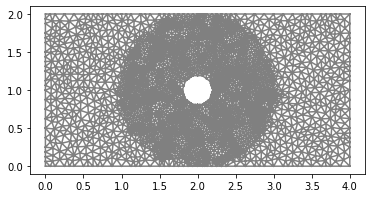

In [127]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(L/2, H/2),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(L/2, H/2)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

We define the finite element approximation. We set the order with which to interpolate the velocity field

In [0]:
def genFunctSpace(order):
  global VE, QE, WE, W, V, Q, w, u,p,v,q;
  # Generate mixed finite element spaces (for velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), order)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W) 

**Define boundary conditions**

The boundary conditions are defined. The velocity in the X direction is set to either positive or negative to change the flow direction. 

In [0]:
def genBC(dir):
  global XMIN, XMAX, YMIN, YMAX, uin, pout, ib, ob, wb;
  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  if(dir):
    uin = Expression(("-4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
  else:
    uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
  pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
  wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problem**

If set, we use _Brezzi-Pitkäranta_ stabilization, as defined in section 5.3 in the lecture notes. The stabilization makes it possible to use the same order interpolation in velocity and pressure fields.

In [0]:
def genProb(stabilize):
  global h, C, gamma, f, residual, w, p, v, dx, u, q, ib, wb, uin, ds;
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h
  c = 1;

  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Define variational problem on residual form: r(u,p;v,q) = 0
  if(stabilize):
    residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
              gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds +
              c*(h**2)*inner(grad(p), grad(q))*dx - 
              inner(f, v)*dx )
  else:
    residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
              gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

  # Solve algebraic system 
  solve(residual == 0, w) 

**Visualize solution and export files**

In [0]:
def run():
  global u,V,p,Q,u1,p1
  !rm results-NS/*

  # Open files to export solution to Paraview
  file_u = File("results-Stokes/u.pvd")
  file_p = File("results-Etokes/p.pvd")

  u1 = project(u, V)
  p1 = project(p, Q)

  # Save solution to file
  file_u << u1
  file_p << p1

  # Plot solution
  plt.figure()
  plot(u1, title="Velocity")

  plt.figure()
  plot(p1, title="Pressure")
  
  plt.show()

  # Export files
  #!tar -czvf results-Stokes.tar.gz results-NS
  #files.download('results-Stokes.tar.gz')

#**Results**

**Original implementation**

In [130]:
genFunctSpace(2);
genBC(False);
genProb(False);
run();

AttributeError: ignored

**Stability**

Mixed order interpolation is stable, as can be seen in the resulting flow above. However, using the same order interpolation for both pressure and velocity fields causes instabilities, as can be seen below in the pressure-plot.

rm: cannot remove 'results-NS/*': No such file or directory


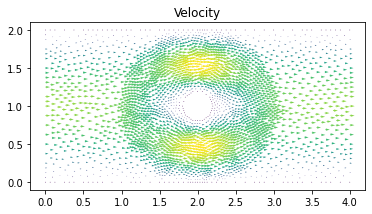

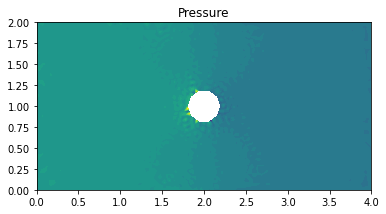

In [125]:
genFunctSpace(1);
genBC(False);
genProb(False);
run();

Stabilizing the interpolation using _Brezzi-Pitkäranta_ stabilization makes the numerical solution stable again, the inaccuracies in the pressure field are no longer present.

rm: cannot remove 'results-NS/*': No such file or directory


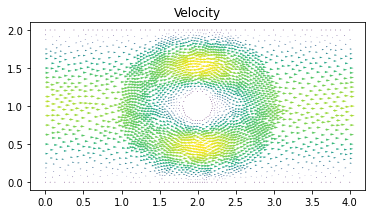

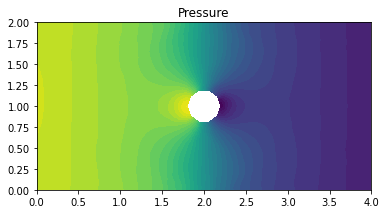

In [123]:
genFunctSpace(1);
genBC(False);
genProb(True);
run();

**Reversing the flow**
To reverse the flow, we simply negate the boundary conditions in the in- and out.flow boundarys, which reverses the flowpattern. 
The pressure gradient is also reversed, and the high pressure zone is now located at the rightmost boundary.

rm: cannot remove 'results-NS/*': No such file or directory


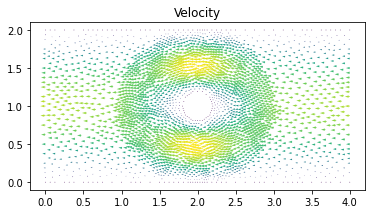

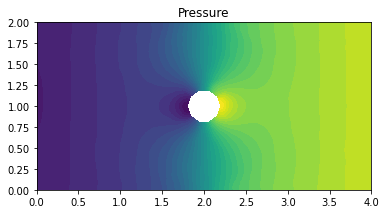

In [122]:
genFunctSpace(1);
genBC(True);
genProb(True);
run();

# **Discussion**

All tested turned out as expected. 